In [1]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [2]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout


def crop_image(image, crop_range):
    return image[crop_range[0][0]:crop_range[0][1], crop_range[1][0]:crop_range[1][1], ...]


def image_loader(image_name, image_size):
    """load image, returns cuda tensor"""
    image = cv2.imread(image_name)
    image= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    im_array = resize(image, (int(image_size[0]), int(image_size[1] )), preserve_range=True)
    image_T = torch.from_numpy(im_array)
    image_T = image_T.type(torch.FloatTensor)
    image_T = image_T.unsqueeze(0)
    image_T = image_T.unsqueeze(0)
    image_T_norm = image_T.sub(image_T.mean()).div(image_T.std())
    return image_T_norm.cuda()


def test_image(image):
        model.set_input(image)
        model.net.eval()
        with torch.no_grad():
            model.forward(split='test')
        scores = model.logits.data.cpu()
        scores = scores.numpy()
        pr_lbls = model.pred
        return scores, pr_lbls

In [2]:
checkpoint_file = 'sononet/checkpoints/300_net_S.pth'
json_filename = 'sononet/config_sononet_8.json'
json_opts = json_file_to_pyobj(json_filename)

In [4]:
with HiddenPrints():
    model = get_model(json_opts.model)

if hasattr(model.net, 'deep_supervised'):
    model.net.deep_supervised = False

    # Load checkpoint
if os.path.isfile(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model.net.load_state_dict(checkpoint)
    print("=> Loaded checkpoint '{}'".format(checkpoint_file))
else:
    print("=> No checkpoint found at '{}'!!!!!!".format(checkpoint_file))

=> Loaded checkpoint 'sononet/checkpoints/300_net_S.pth'


In [3]:
foo = h5py.File('data/image_inp_224x288.hdf5')

In [6]:
list(foo.keys())

['annotation_labels_test',
 'annotation_labels_train',
 'data_mean',
 'domain_labels_test',
 'domain_labels_train',
 'images_test',
 'images_train',
 'label_names',
 'label_numbers',
 'mean_image',
 'plane_labels_test',
 'plane_labels_train']

In [4]:
cardiac_classes = [1, 2, 22, 29]

In [5]:
card_train_id = np.array([i in cardiac_classes for i in foo['plane_labels_train'].value])
card_test_id = np.array([i in cardiac_classes for i in foo['plane_labels_test'].value])

In [6]:
card_images_train = torch.tensor(foo['images_train'][card_train_id,:,:,:])
card_labels_train = torch.tensor(foo['plane_labels_train'][card_train_id])

In [36]:
means = card_images_train.view(len(card_images_train),-1).float().mean(dim=1).view(-1,1,1,1)
stds = card_images_train.view(len(card_images_train),-1).float().std(dim=1).view(-1,1,1,1)
card_images_train_transformed = card_images_train.sub(means).div(stds)

In [39]:
card_trainloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(card_images_train_transformed),
    shuffle=False,
    batch_size=50
)

In [7]:
card_images_test = torch.tensor(foo['images_test'][card_test_id,:,:,:])
card_labels_test = torch.tensor(foo['plane_labels_test'][card_test_id])

In [38]:
means = card_images_test.view(len(card_images_test),-1).float().mean(dim=1).view(-1,1,1,1)
stds = card_images_test.view(len(card_images_test),-1).float().std(dim=1).view(-1,1,1,1)
card_images_test_transformed = card_images_test.sub(means).div(stds)

In [40]:
card_testloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(card_images_test_transformed),
    shuffle=False,
    batch_size=50
)

In [ ]:
# images_test = torch.tensor(foo['images_test'])

In [114]:
# means = images_test.view(len(images_test),-1).float().mean(dim=1).view(-1,1,1,1)
# stds = images_test.view(len(images_test),-1).float().std(dim=1).view(-1,1,1,1)
# images_test_transformed = images_test.sub(means).div(stds)

In [115]:
# testloader = torch.utils.data.DataLoader(
#     torch.utils.data.TensorDataset(images_test_transformed),
#     shuffle=False,
#     batch_size=50
# )

In [8]:
class StratifiedSampler(object):
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.class_vector = class_vector
        self.batch_size = batch_size
        self.num_iter = len(class_vector) // 52
        self.n_class = 14
        self.sample_n = 2
        # create pool of each vectors
        indices = {}
        for i in range(self.n_class):
            indices[i] = np.where(self.class_vector == i)[0]

        self.indices = indices
        self.background_index = np.argmax([ len(indices[i]) for i in range(self.n_class)])

    def gen_sample_array(self):
        # sample 2 from each class
        sample_array = []
        for i in range(self.num_iter):
            arrs = []
            for i in range(self.n_class):
                n = self.sample_n
                if i == self.background_index:
                    n = self.sample_n * (self.n_class-1)
                arr = np.random.choice(self.indices[i], n)
                arrs.append(arr)

            sample_array.append(np.hstack(arrs))
        return np.hstack(sample_array)

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [11]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = 1. / lab_count

        # data augmentation
        self.transform = transform

        # report the number of images in the dataset
        # print('Number of {0} images: {1} NIFTIs'.format(split, self.__len__()))

    def __getitem__(self, index):
        # update the seed to avoid workers sample the same augmentation parameters
        # np.random.seed(datetime.datetime.now().second + datetime.datetime.now().microsecond)

        # load the nifti images
        indata  = self.images[index][0]
        target = self.labels[index]

        #input = input.transpose((1,2,0))

        # handle exceptions
        #check_exceptions(input, target)
        if self.transform:
            indata = self.transform(indata.numpy())

        #print(input.shape, torch.from_numpy(np.array([target])))
        #print("target",np.int64(target))
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [14]:
def train(config, debug):

    # Parse input arguments
    json_filename = config
    network_debug = debug

    # Load options
    json_opts = json_file_to_pyobj(json_filename)
    train_opts = json_opts.training # false

    # Architecture type
    arch_type = train_opts.arch_type

    # Setup Dataset and Augmentation
    ds_class = get_dataset(arch_type)
    ds_path  = get_dataset_path(arch_type, json_opts.data_path)
    ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)

    # Setup the NN Model
    model = get_model(json_opts.model)
    if network_debug:
        print('# of pars: ', model.get_number_parameters())
        print('fp time: {0:.3f} sec\tbp time: {1:.3f} sec per sample'.format(*model.get_fp_bp_time()))
        exit()

    # Setup Data Loader
    num_workers = train_opts.num_workers if hasattr(train_opts, 'num_workers') else 0 #16
    train_dataset = SimpleUSDataset(
        (card_images_train.float(), card_labels_train),
        transform=ds_transform['train'])
#    valid_dataset = ds_class(ds_path, split='val',   transform=ds_transform['valid'], preload_data=train_opts.preloadData)
    test_dataset = SimpleUSDataset(
        (card_images_test.float(), card_labels_test),
        transform=ds_transform['train'])
    # test_dataset  = ds_class(ds_path, split='test',  transform=ds_transform['valid'], preload_data=train_opts.preloadData)

    # create sampler
    if train_opts.sampler == 'stratified':
        print('stratified sampler')
        train_sampler = StratifiedSampler(train_dataset.labels, train_opts.batchSize)
        batch_size = 52
    elif train_opts.sampler == 'weighted2':
        print('weighted sampler with background weight={}x'.format(train_opts.bgd_weight_multiplier))
        # modify and increase background weight
        weight = train_dataset.weight
        bgd_weight = np.min(weight)
        weight[abs(weight - bgd_weight) < 1e-8] = bgd_weight * train_opts.bgd_weight_multiplier
        train_sampler = sampler.WeightedRandomSampler(weight, len(train_dataset.weight))
        batch_size = train_opts.batchSize
    else:
        print('weighted sampler')
        train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, len(train_dataset.weight))
        batch_size = train_opts.batchSize

    # loader
    train_loader = DataLoader(dataset=train_dataset, num_workers=num_workers,
                              batch_size=batch_size, sampler=train_sampler)
    # valid_loader = DataLoader(dataset=valid_dataset, num_workers=num_workers, batch_size=train_opts.batchSize, shuffle=True)
    test_loader  = DataLoader(dataset=test_dataset,  num_workers=num_workers, batch_size=train_opts.batchSize, shuffle=True)

    # Visualisation Parameters
    visualizer = Visualiser(json_opts.visualisation, save_dir=model.save_dir)
    error_logger = ErrorLogger()

    # Training Function
    track_labels = np.arange(len(train_dataset.label_names))
    model.set_labels(track_labels)
    model.set_scheduler(train_opts)
    
    if hasattr(model, 'update_state'):
        model.update_state(0)

    for epoch in range(model.which_epoch, train_opts.n_epochs):
        print('(epoch: %d, total # iters: %d)' % (epoch, len(train_loader)))

        # # # --- Start ---
        # import matplotlib.pyplot as plt
        # plt.ion()
        # plt.figure()
        # target_arr = np.zeros(14)
        # # # --- End ---

        # Training Iterations
        for epoch_iter, (images, labels) in tqdm(enumerate(train_loader, 1), total=len(train_loader)):
            # Make a training update
            model.set_input(images, labels)
            model.optimize_parameters()

            if epoch == (train_opts.n_epochs-1):
                import time
                time.sleep(36000)

            if train_opts.max_it == epoch_iter:
                break

            # # # --- visualise distribution ---
            # for lab in labels.numpy():
            #     target_arr[lab] += 1
            # plt.clf(); plt.bar(train_dataset.label_names, target_arr); plt.pause(0.01)
            # # # --- End ---

                # Visualise predictions
            if epoch_iter <= 100:
                visuals = model.get_current_visuals()
                visualizer.display_current_results(visuals, epoch=epoch, save_result=False)

            # Error visualisation
            errors = model.get_current_errors()
            error_logger.update(errors, split='train')

        # # Validation and Testing Iterations
        # pr_lbls = []
        # gt_lbls = []
        # # removed validation loader
        # for loader, split in zip([test_loader], ['test']):
        #     model.reset_results()

        #     for epoch_iter, (images, labels) in tqdm(enumerate(loader, 1), total=len(loader)):

        #         # Make a forward pass with the model
        #         model.set_input(images, labels)
        #         model.validate()

        #         # Visualise predictions
        #         visuals = model.get_current_visuals()
        #         visualizer.display_current_results(visuals, epoch=epoch, save_result=False)

        #         if train_opts.max_it == epoch_iter:
        #             break

        #     # Error visualisation
        #     errors = model.get_accumulated_errors()
        #     stats = model.get_classification_stats()
        #     error_logger.update({**errors, **stats}, split=split)

        #     # HACK save validation error
        #     if split == 'validation':
        #         valid_err = errors['CE']

        # # Update the plots
        # for split in ['train', 'test']:
        #     # exclude background
        #     # track_labels = np.delete(track_labels, 3)
        #     # show_labels = train_dataset.label_names[:3] + train_dataset.label_names[4:]
        #     show_labels = train_dataset.label_names
        #     visualizer.plot_current_errors(epoch, error_logger.get_errors(split), split_name=split, labels=show_labels)
        #     visualizer.print_current_errors(epoch, error_logger.get_errors(split), split_name=split)
        # error_logger.reset()

        # Save the model parameters
        if epoch % train_opts.save_epoch_freq == 0:
            model.save(epoch)

        if hasattr(model, 'update_state'):
            model.update_state(epoch)

        # Update the model learning rate
        model.update_learning_rate(metric=valid_err, epoch=epoch)

In [15]:
train('sononet/config_sononet_8_andi.json', False)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################



Initialising model sononet2


RuntimeError: CUDA error: device-side assert triggered

In [38]:
json_file_to_pyobj('sononet/config_sononet_8_andi.json')
train_dataset = SimpleUSDataset(
        (card_images_train.float(), card_labels_train),
        transform=get_dataset_transformation(bazoo.training.arch_type, bazoo.augmentation)['train'])



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [64]:
train_loader = DataLoader(train_dataset, num_workers=0, batch_size=10,
    sampler=sampler.WeightedRandomSampler(train_dataset.weight, 10)
    )

In [66]:
for idx, (d, i) in enumerate(train_loader):
    test_image_batch_2 = d
    break

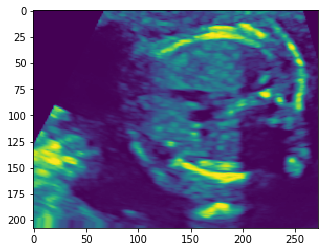

In [69]:
plt.imshow(test_image_batch_1[0,0])